In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg

#df_anno = pd.read_feather("anno.feather")
df_V1 = pd.read_csv("./Human_Cortical/V1/CrossAreal_V1_RSC-122-359_ann_map_full_QC.csv")
df_M1 = pd.read_csv("./Human_Cortical/M1/CrossAreal_M1_RSC-122-359_ann_map_full_QC.csv")
df_DLPFC = pd.read_csv("./Human_Cortical/DLPFC/CrossAreal_DLPFC_RSC-122-359_ann_map_full_QC.csv")
df_MTG = pd.read_csv("./Human_Cortical/MTG/CrossAreal_MTG_RSC-122-359_ann_map_full_QC.csv")


/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_17395/1930722306.py:8: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_V1 = pd.read_csv("./Human_Cortical/V1/CrossAreal_V1_RSC-122-359_ann_map_full_QC.csv")
/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_17395/1930722306.py:9: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_M1 = pd.read_csv("./Human_Cortical/M1/CrossAreal_M1_RSC-122-359_ann_map_full_QC.csv")
/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_17395/1930722306.py:10: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DLPFC = pd.read_csv("./Human_Cortical/DLPFC/CrossAreal_DLPFC_RSC-122-359_ann_map_full_QC.csv")
/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_17395/1930722306.py:11: DtypeWarning: Columns (41,126,140,151) have mixed

In [101]:
df_V1.shape

(7097, 179)

In [102]:
#df_V1 = df_V1[[roi in ["OCx","VISp"] for roi in df_V1.roi]]
# Overwrites Region column
df_V1 = df_V1[df_V1['roi'].str.contains('OCx|VISp').fillna(False)]
df_V1['Region'] = 'Occipital'
df_V1.shape

(389, 179)

In [103]:
df_MTG = df_MTG[df_MTG['roi'].str.contains('TCx|Tcx|TEa').fillna(False)]
df_MTG['Region'] = 'Temporal'

In [104]:
df_M1_FCx = df_M1[df_M1['roi'].str.contains('FCx').fillna(False)]
df_M1 = df_M1[df_M1['roi'].str.contains('MOp').fillna(False)]
df_M1['Region'] = 'Frontal'

In [105]:
df_DLPFC_FCx = df_DLPFC[df_DLPFC['roi'].str.contains('FCx').fillna(False)]
df_DLPFC = df_DLPFC[df_DLPFC['roi'].str.contains('dlPFC').fillna(False)]
df_DLPFC['Region'] = 'Frontal'

In [106]:
# Find cells that map the same in df_M1 and df_DLPFC atlases, change label to FCx
# Because Tree mapping confusions are much more sensible, we will use Tree mapping results

df_FCx = df_M1_FCx
df_FCx['Region'] = 'Frontal'

print(df_FCx.shape)   # Lost a lot of samples

(1585, 179)


In [107]:
# Join with MTG, V1, M1
df_main = pd.concat([df_V1, df_MTG, df_M1, df_DLPFC, df_FCx], axis=0, join='outer')
print(df_main.shape)

(6010, 179)


In [108]:
df_id = pd.read_csv("./custom_report.csv")
df2 = pd.merge(df_main, df_id, how='inner', left_on='cell_name', right_on='cell_specimen_name ', sort=True)
df2.shape

(3125, 247)

In [253]:
# Merge with features sheet
df_ephys = pd.read_csv("./ephys_features_20240426.csv")
df_ephys.columns
df3 = pd.merge(df2, df_ephys, how='inner', left_on='cell_specimen_id ', right_on='cell_name', sort=True)
print(df3.shape)
df3['CrossArea_subclass_Tree'].value_counts()

(3121, 360)


Sst           525
Pvalb         470
L4 IT         437
L2/3 IT       423
L6 CT         199
Sncg          193
Lamp5         183
Vip           155
Pax6          122
L6b            82
L5/6 NP        71
Chandelier     57
L5 IT          50
L6 IT          45
Lamp5 Lhx6     40
Sst Chodl      28
L6 IT Car3     26
L5 ET          15
Name: CrossArea_subclass_Tree, dtype: int64

(array([12., 46., 72., 59., 48., 55., 65., 77., 66., 25.]),
 array([0.02349001, 0.13524484, 0.24699967, 0.3587545 , 0.47050933,
        0.58226416, 0.69401899, 0.80577383, 0.91752866, 1.02928349,
        1.14103832]),
 <BarContainer object of 10 artists>)

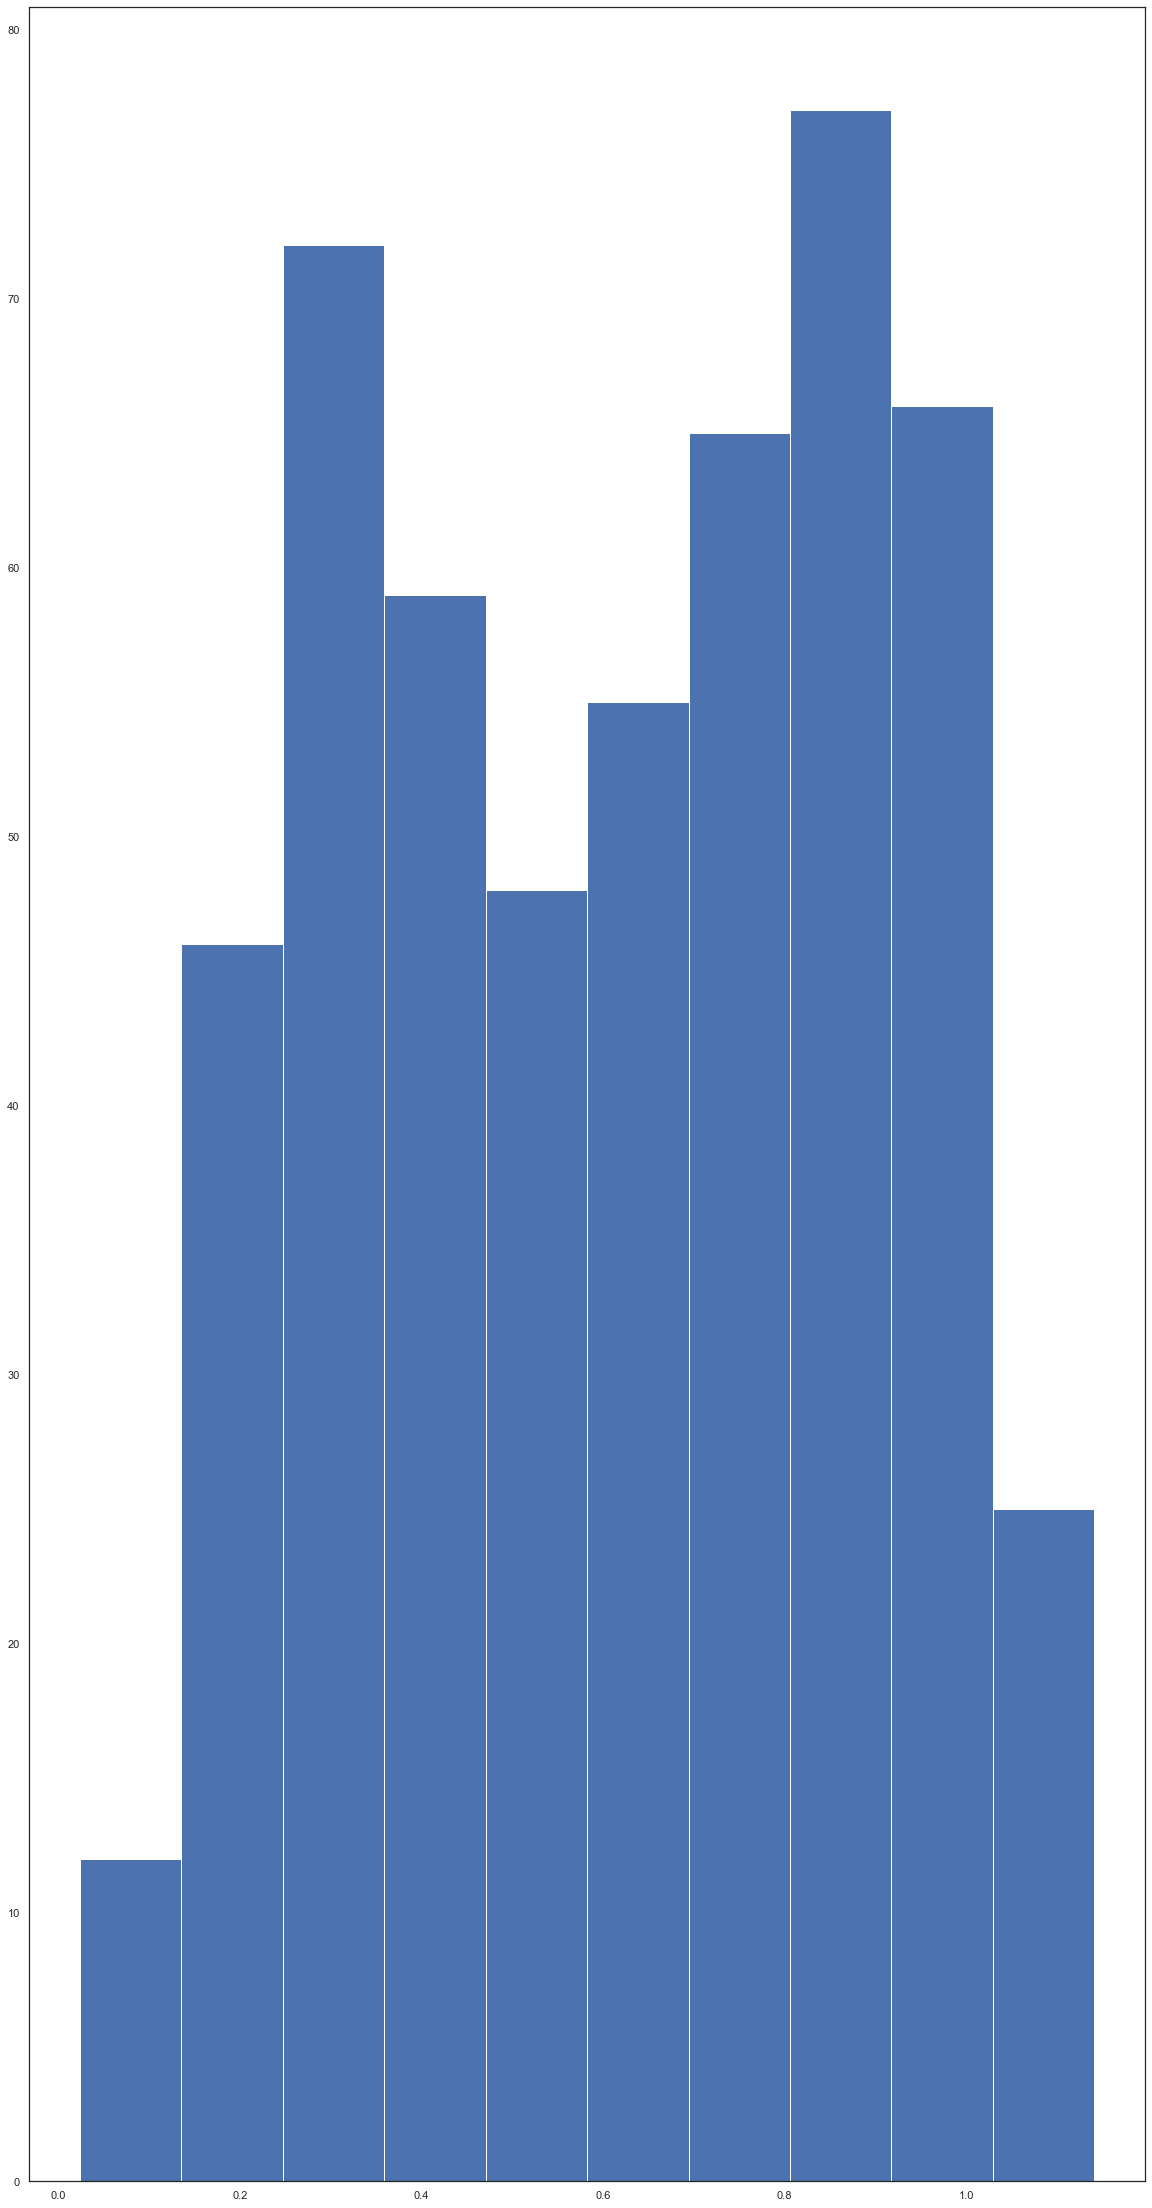

In [116]:
df3b = df3[[sc in ['Sst'] for sc in df3['CrossArea_subclass_Tree']]]
plt.hist(df3b['marker_sum_norm_label'])

In [254]:
# QC filter joined list

df3_filt = df3[df3['percent_reads_aligned_total']>=25]    # was 50%
print(len(df3_filt))
df3_filt = df3_filt[df3_filt['Genes.Detected']>=1000]
print(len(df3_filt))
#df3_filt = df3_filt[df3_filt['score.Corr']>=0.55]
df3_filt = df3_filt[df3_filt['marker_sum_norm_label'] >= 0.55]
print(len(df3_filt))
#df3_filt = df3_filt[df3_filt['rna_amplification_pass_fail_label']=='Pass']
print(len(df3_filt))
# Layer labels have no numerics, no need to filter
df3_filt['CrossArea_subclass_Tree'].value_counts()

3101
2998
2060
2060


L4 IT         401
L2/3 IT       374
Pvalb         346
Sst           299
Lamp5         125
Sncg          113
Vip            85
Pax6           68
L6 CT          55
L5/6 NP        39
L5 IT          34
L6 IT          33
Lamp5 Lhx6     27
L6b            26
Chandelier     15
L6 IT Car3     13
Sst Chodl       6
L5 ET           1
Name: CrossArea_subclass_Tree, dtype: int64

In [255]:
# Subset to Sst
df4 = df3_filt[[sc in ['Sst'] for sc in df3_filt['CrossArea_subclass_Tree']]]
df4.shape
df4.to_csv('SST_ephys_anno.csv', index=False) 

In [256]:
df4.shape

(299, 360)

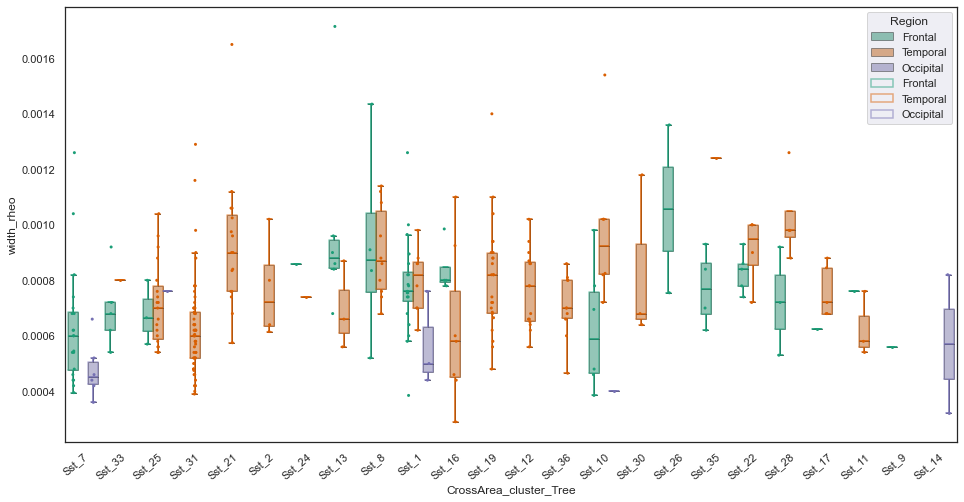

In [119]:
# plot by cluster and roi

def plot_property (df, feature, feat_name, ax):
    #order = ['L2/3 IT_1','L2/3 IT_2','L2/3 IT_3','L2/3 IT_4','L2/3 IT_5','L2/3 IT_6','L4 IT_1','L4 IT_2','L4 IT_3','L4 IT_4','L4 IT_5', 'L4 IT_6']
    #order = [cat for cat in order if df["CrossArea_cluster_Tree"].str.contains(cat).any()]
    plt.axes(ax)
    sns.boxplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 showfliers=False, boxprops=dict(alpha=.5), data=df)  
    sns.stripplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 data=df4, ax=ax, dodge=True, legend = False, size=3)
    sns.boxplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 showfliers=False, fill = False, color = 'k', boxprops=dict(alpha=.5), data=df)  
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
    plt.xticks(rotation = 40, ha='right', rotation_mode='anchor')
    # adding transparency to colors
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    plt.show()

fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'width_rheo', 'Spike width (ms)', ax1)

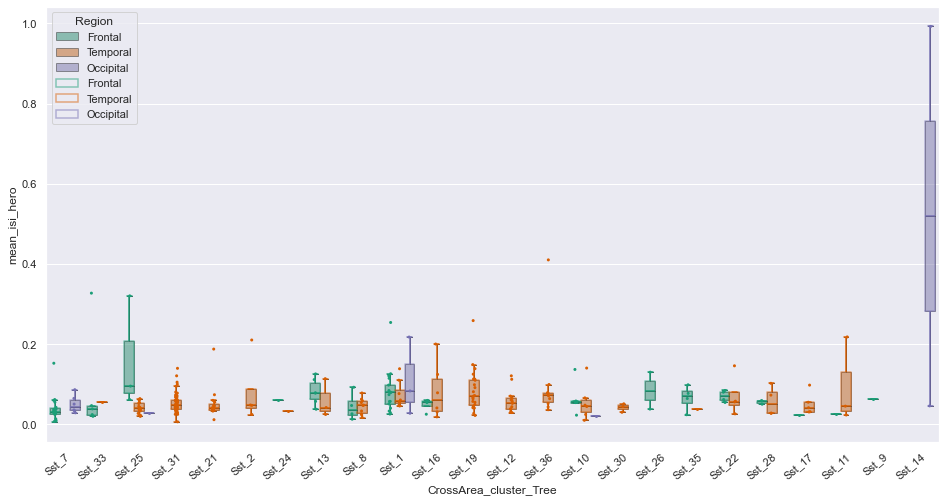

In [120]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'mean_isi_hero', 'Mean ISI (s)', ax1)

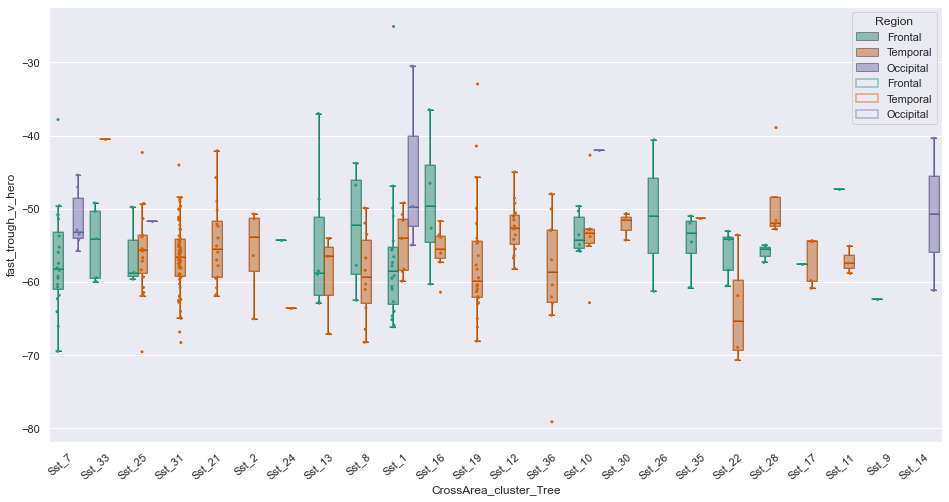

In [121]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'fast_trough_v_hero', 'Fast trough V (mV)', ax1)

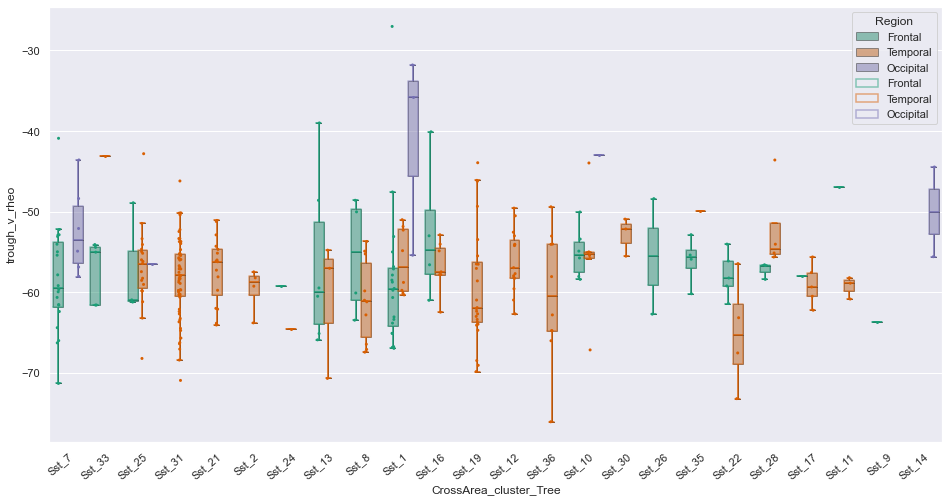

In [122]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'trough_v_rheo', 'Trough V (mV)', ax1)

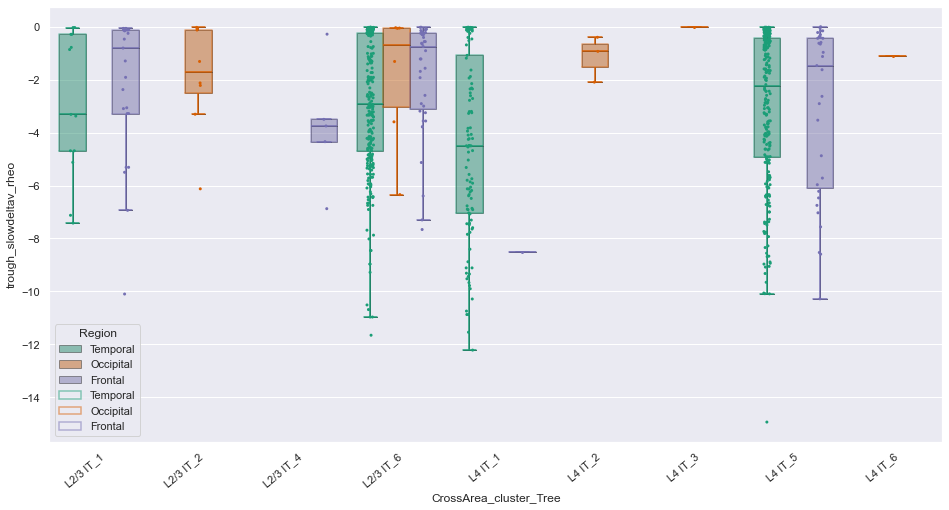

In [82]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'trough_slowdeltav_rheo', r'Slow AHP $\Delta$V (mV)', ax1)

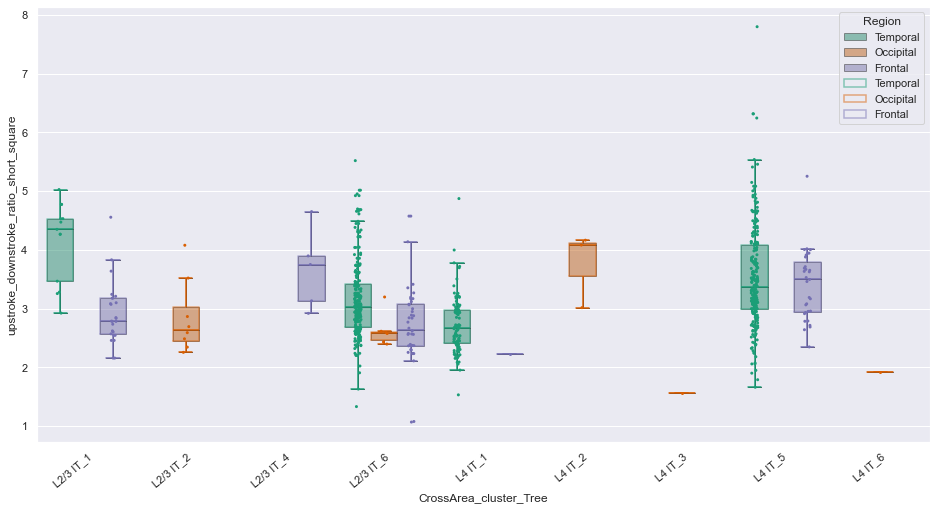

In [83]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'upstroke_downstroke_ratio_short_square', 'Upstroke/Downstroke', ax1)

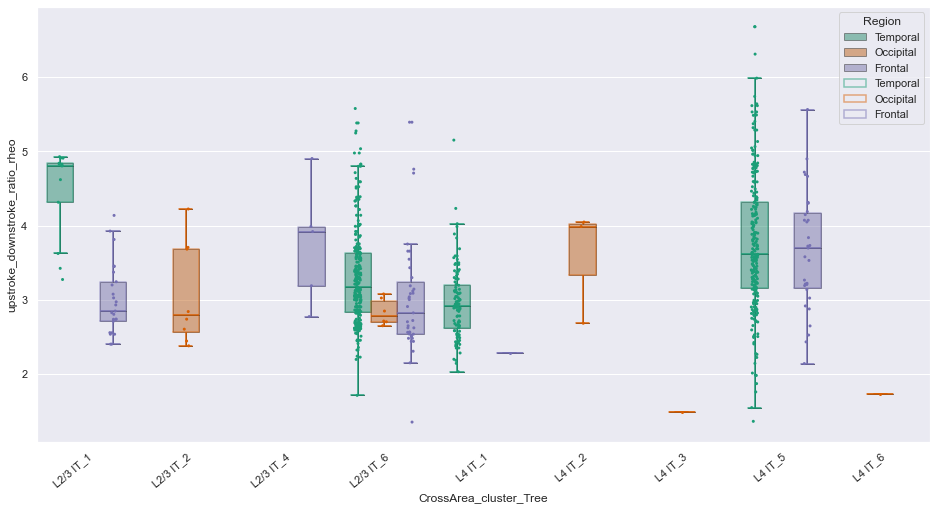

In [84]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'upstroke_downstroke_ratio_rheo', 'Upstroke-downstroke ratio rheo', ax1)

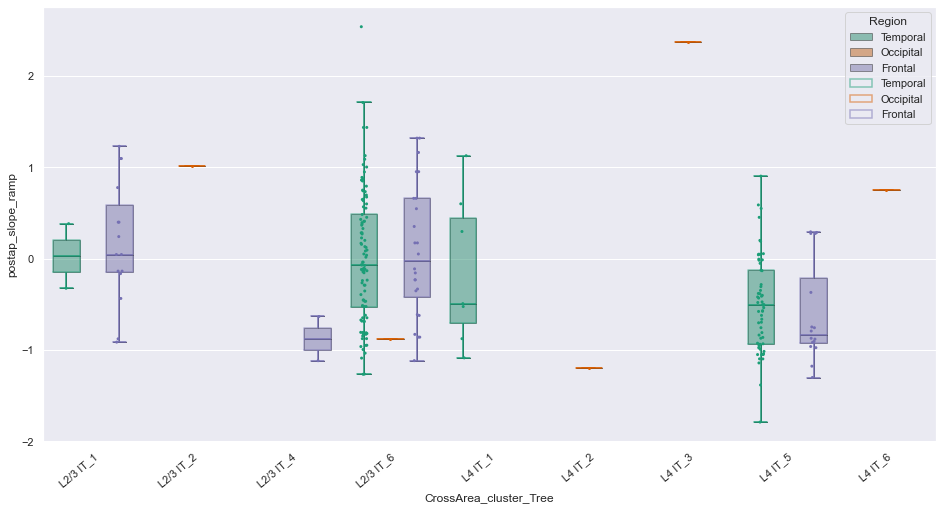

In [85]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'postap_slope_ramp', '', ax1)

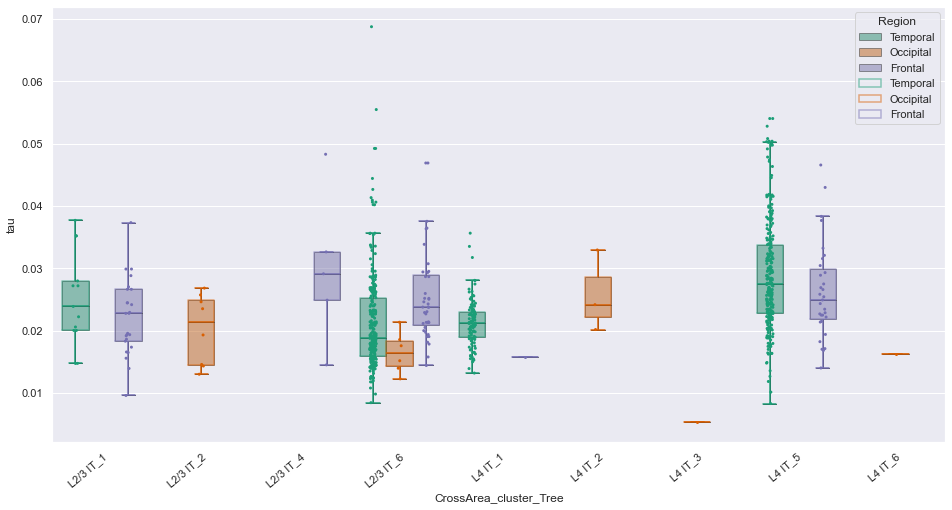

In [86]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'tau', r'Membrane $\tau$ (ms)', ax1)

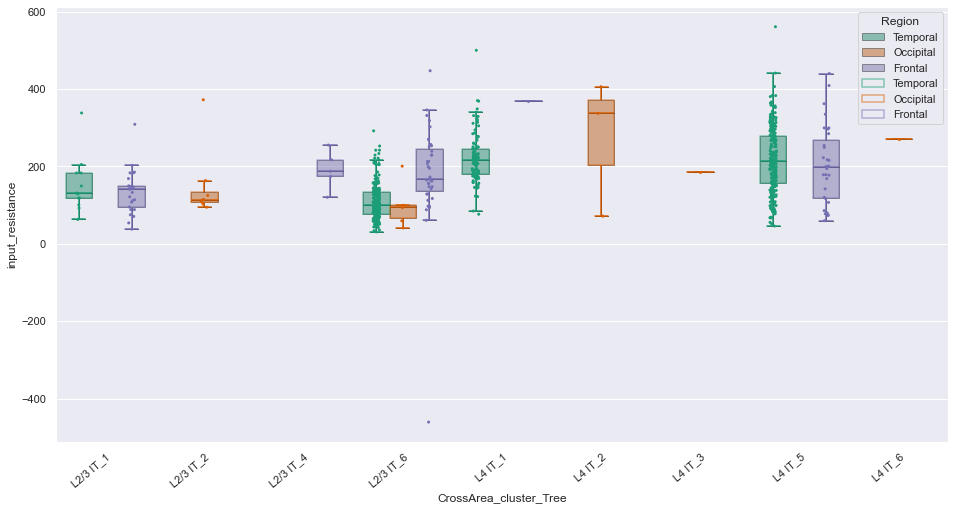

In [87]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'input_resistance', 'R$_{in}$ (M$\Omega$)', ax1)

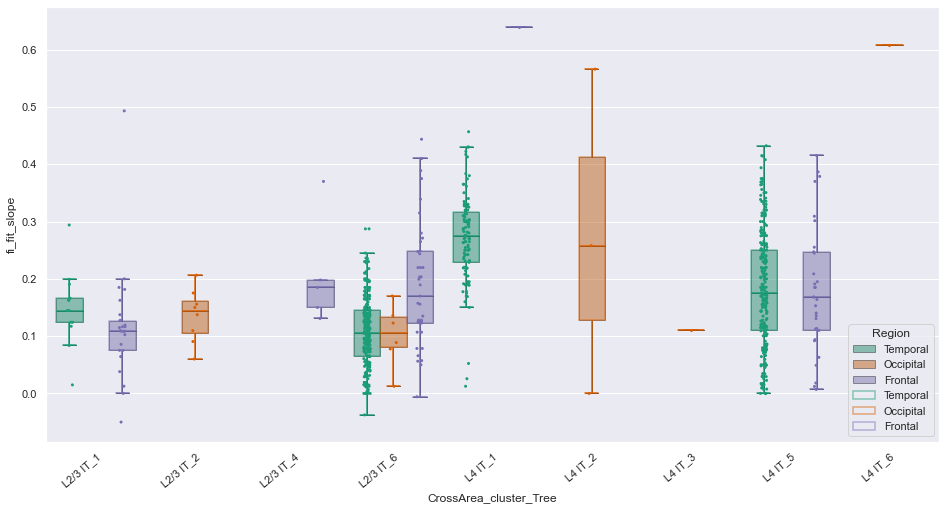

In [88]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'fi_fit_slope', 'F-I Slope', ax1)

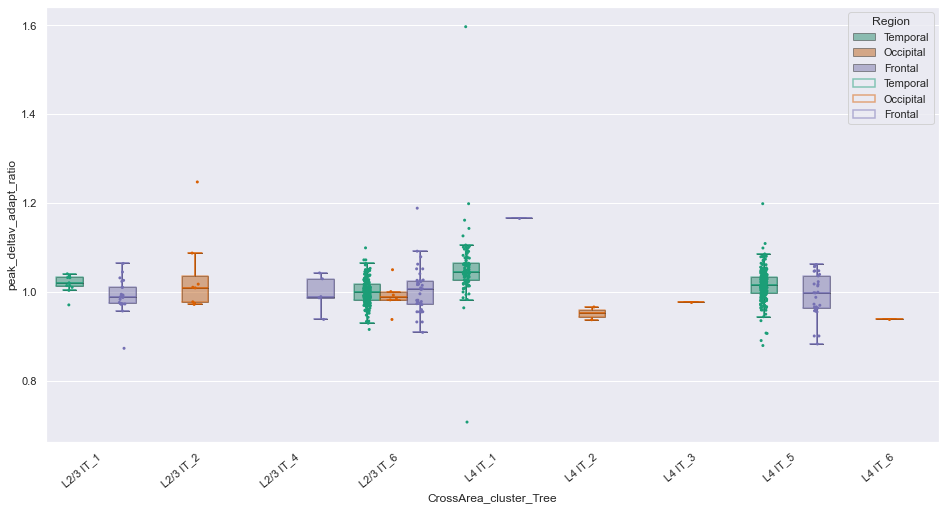

In [89]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'peak_deltav_adapt_ratio', 'peak_deltav_adapt_ratio', ax1)

In [216]:
df4.columns[266:360]

Index(['upstroke_downstroke_ratio_short_square', 'threshold_v_short_square',
       'width_short_square', 'upstroke_short_square',
       'downstroke_short_square', 'width_suprathresh_short_square',
       'peak_deltav_short_square', 'sag', 'sag_area', 'sag_tau', 'v_baseline',
       'rheobase_i', 'fi_fit_slope', 'vm_for_sag', 'input_resistance',
       'input_resistance_ss', 'tau', 'latency_rheo', 'avg_rate_rheo',
       'mean_isi_rheo', 'upstroke_downstroke_ratio_rheo', 'threshold_v_rheo',
       'peak_v_rheo', 'width_rheo', 'upstroke_rheo', 'downstroke_rheo',
       'width_suprathresh_rheo', 'trough_v_rheo', 'fast_trough_v_rheo',
       'postap_slope_rheo', 'fast_trough_v_last_rheo', 'adp_v_last_rheo',
       'adapt_hero', 'avg_rate_hero', 'latency_hero', 'mean_isi_hero',
       'median_isi_hero', 'isi_cv_hero', 'ir_late_hero',
       'upstroke_downstroke_ratio_hero', 'threshold_v_hero', 'peak_v_hero',
       'width_hero', 'upstroke_hero', 'downstroke_hero',
       'width_suprathres

In [227]:
counts = df4.iloc[:,266:360].isna().sum()

print(counts.to_string())

upstroke_downstroke_ratio_short_square      8
threshold_v_short_square                    8
width_short_square                          8
upstroke_short_square                       8
downstroke_short_square                     8
width_suprathresh_short_square             11
peak_deltav_short_square                    8
sag                                        14
sag_area                                   14
sag_tau                                    69
v_baseline                                 14
rheobase_i                                 14
fi_fit_slope                               14
vm_for_sag                                 14
input_resistance                           14
input_resistance_ss                        14
tau                                        15
latency_rheo                               14
avg_rate_rheo                              14
mean_isi_rheo                             193
upstroke_downstroke_ratio_rheo             14
threshold_v_rheo                  

In [257]:
df4 = df4.set_index('exp_component_name')

df4.head()

,Unnamed: 0,Row.names,score.Corr,score.Tree,Class_Corr,CrossArea_subclass_Corr,CrossArea_cluster_Corr,Class_Tree,CrossArea_subclass_Tree,CrossArea_cluster_Tree,...,peak_deltav_ramp,peak_ratio_chirp,peak_freq_chirp,3db_freq_chirp,peak_impedance_chirp,low_freq_impedance_chirp,sync_freq_chirp,phase_peak_chirp,phase_low_chirp,total_inductive_phase_chirp
exp_component_name,,,,,,,,,,,,,,,,,,,,,
SM-GE64T_S119_E1-50,36,SM-GE64T_S119_E1-50,0.445903,0.95,inhibitory,Sst,Sst_7,inhibitory,Sst,Sst_7,...,48.843754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SM-GE64T_S120_E1-50,37,SM-GE64T_S120_E1-50,0.467015,0.36,inhibitory,Sst,Sst_25,inhibitory,Sst,Sst_33,...,73.468756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SM-GE64V_S097_E1-50,40,SM-GE64V_S097_E1-50,0.345609,0.25,inhibitory,Pvalb,Pvalb_7,inhibitory,Sst,Sst_7,...,83.156254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SM-GE65R_S005_E1-50,102,SM-GE65R_S005_E1-50,0.682652,0.90,inhibitory,Sst,Sst_25,inhibitory,Sst,Sst_25,...,71.031256,1.207202,3.201281,8.703481,0.241646,0.200171,1.400560,-0.251202,0.125475,0.006555
SM-GE65H_S028_E1-50,134,SM-GE65H_S028_E1-50,0.335442,0.20,inhibitory,Pvalb,Pvalb_6,inhibitory,Sst,Sst_7,...,75.125008,1.006089,1.000298,4.101222,0.296037,0.294246,0.400119,-0.204302,-0.045440,0.000000


In [258]:
# Remove any features with more than 28 nan's
df_counts = pd.DataFrame(counts)
df_counts = df_counts.T
df_counts.reset_index(drop=True, inplace=True)
foo = [df_counts[feat][0] for feat in df_counts.columns]

df_trim = df4[df_counts.columns[np.array(foo)<=28]]
df_trim.shape

(299, 64)

In [259]:
df_trim = df_trim.dropna()
df_trim.shape
df_trim.head()

,upstroke_downstroke_ratio_short_square,threshold_v_short_square,width_short_square,upstroke_short_square,downstroke_short_square,width_suprathresh_short_square,peak_deltav_short_square,sag,sag_area,v_baseline,...,peak_deltav_adapt_ratio,peak_deltav_5th_adapt_ratio,ahp_delay_ratio_5spike,trough_slowdeltav_rheo,trough_slowdeltav_hero,fast_trough_deltav_rheo,fast_trough_deltav_hero,peak_deltav_rheo,peak_deltav_hero,first_isi_inv_hero
exp_component_name,,,,,,,,,,,,,,,,,,,,,
SM-GE64T_S119_E1-50,1.625777,-42.281250,0.000580,249.685618,-153.579224,0.000420,50.281250,0.084803,0.000000,-74.076576,...,1.032643,1.022691,0.009755,-0.468742,-0.125000,-27.468758,-21.093758,50.562500,57.718750,41.390728
SM-GE65R_S005_E1-50,2.179622,-42.937504,0.000740,246.806579,-113.233683,0.000680,70.687506,0.558593,0.827259,-57.016525,...,0.981159,0.985870,0.143313,-7.062500,-0.249996,-7.968750,-7.562504,71.218754,71.468752,38.759690
SM-GE65H_S028_E1-50,2.850642,-43.812504,0.000920,253.289220,-88.853393,0.000840,75.625004,0.127273,0.729565,-69.916061,...,1.038966,1.033652,0.130338,-1.343750,-0.468750,-11.781254,-10.187504,77.406254,77.562504,21.367521
SM-GE66Q_S019_E1-50,1.806691,-41.156251,0.000427,442.278764,-244.842146,0.000340,69.041670,0.371542,1.274548,-66.685547,...,0.977904,0.978239,0.044776,-0.125000,-0.281258,-29.750000,-28.687496,63.593752,64.375004,7.814942
SM-GE8ZX_S174_E1-50,1.710528,-24.320314,0.000585,273.160460,-159.693076,0.000435,54.453129,0.112374,0.544689,-61.654583,...,1.012686,1.017035,0.033144,-1.125004,-1.687500,-31.031250,-25.781248,56.531252,58.750004,27.886224


In [260]:
from sklearn.decomposition import PCA   # can't deal with missing data, scary to impute
from sklearn.preprocessing import StandardScaler, RobustScaler

X_std = StandardScaler().fit_transform(df_trim)

pca = PCA(n_components=10)
X_new = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)

X_new.shape
columns = ['pca_comp_%i' % (i+1) for i in range(X_new.shape[1])]
df_PCA = pd.DataFrame(X_new, columns=columns, index = df_trim.index)
df_PCA = pd.concat([df_trim, df_PCA], axis=1, join='inner')
df_PCA.shape
#df_PCA = df_trim.append(df_PCA)

[0.20881813 0.11387322 0.10986099 0.08223821 0.07277344 0.05807239
 0.04119579 0.03150806 0.02801385 0.02724207]


(262, 74)

In [275]:
comps = pca.components_
comps.shape
# Get coefficients of first three eigenvectors - or for now, just export the transformed values with cell IDs and explained variance
df_comps = pd.DataFrame(comps[0,:], index = df_trim.columns[0:64])
df_comps = df_comps.sort_values(by = [0])
df_comps

,0
upstroke_adapt_ratio,-0.175882
downstroke_adapt_ratio,-0.169691
upstroke_short_square,-0.164161
vm_for_sag,-0.152806
upstroke_hero,-0.147316
...,...
width_hero,0.238703
downstroke_short_square,0.240020
width_suprathresh_rheo,0.244574
downstroke_hero,0.246881


In [261]:
df_PCA.columns
df_PCA.to_csv('SST_PCA.csv', index=True) 

In [198]:
np.min(X_std[:,3])

-3.395247344087132

In [169]:
df_counts

,upstroke_downstroke_ratio_short_square,threshold_v_short_square,width_short_square,upstroke_short_square,downstroke_short_square,width_suprathresh_short_square,peak_deltav_short_square,sag,sag_area,sag_tau,...,peak_deltav_ramp,peak_ratio_chirp,peak_freq_chirp,3db_freq_chirp,peak_impedance_chirp,low_freq_impedance_chirp,sync_freq_chirp,phase_peak_chirp,phase_low_chirp,total_inductive_phase_chirp
0,8,8,8,8,8,11,8,14,14,69,...,248,198,198,198,198,198,198,198,198,198


In [ ]:
# Exploring pinned locations - concluded these are incomplete and have accuracy issues
df_pins = pd.read_excel("./Human_Exc_cortical_pinning.xlsx")

In [ ]:
df_pins[df_pins.lobe=='TemL']['structure'].value_counts()

In [ ]:
df_pins[df_pins.lobe=='OccL']['structure'].value_counts()

In [93]:
df_pins[df_pins.lobe=='FroL']['structure'].value_counts()

MFG      67
SFG      48
FroL     45
LOrG      4
IFGtr     3
PaCG      2
Name: structure, dtype: int64

In [ ]:
df_V1 = df_V1.rename(columns={'structure': 'structure_anno'})

In [ ]:
merged_V1 = pd.merge(df_pins, df_V1, how='outer', on='cell_id')
sub = merged_V1[['cell_id', 'CrossArea_subclass_Tree', 'CrossArea_subclass_Corr', 'CrossArea_cluster_Tree', 'CrossArea_cluster_Corr','cell_specimen_project','roi', 'structure', 'lobe', 'cortex_layer']]

In [ ]:
#sub = sub[sub['lobe']=='OccL']
sub = sub[sub['roi'].str.contains('VISp').fillna(False)]
sub